<a href="https://colab.research.google.com/github/Kabshah/AI-try/blob/main/cnn_pr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cupshah","key":"af5f6a202ed1974334507b48cad0bcaf"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d phylake1337/fire-dataset

Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0
 91% 354M/387M [00:00<00:00, 418MB/s]
100% 387M/387M [00:00<00:00, 427MB/s]


In [5]:

!unzip fire-dataset.zip -d /content/dataset

Archive:  fire-dataset.zip
  inflating: /content/dataset/fire_dataset/fire_images/fire.1.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.10.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.100.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.101.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.102.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.103.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.104.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.105.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.106.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.107.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.108.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.109.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.11.png  
  inflating: /content/dataset/fire_dataset/fire_images/fire.110.png

In [6]:
import os
print(os.listdir("/content/dataset"))

['fire_dataset']


In [7]:
data_dir = "/content/dataset/fire_dataset"

classes = os.listdir(data_dir)
print("Classes:", classes)

for cls in classes:
    count = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"{cls}: {count} images")

Classes: ['non_fire_images', 'fire_images']
non_fire_images: 244 images
fire_images: 755 images


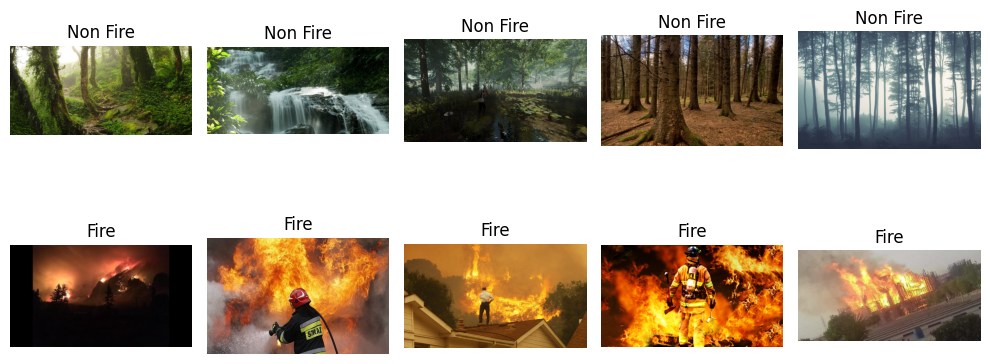

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

data_dir = "/content/dataset/fire_dataset"
non_fire_dir = os.path.join(data_dir, 'non_fire_images')
fire_dir = os.path.join(data_dir, 'fire_images')

non_fire_images = os.listdir(non_fire_dir)
fire_images = os.listdir(fire_dir)

plt.figure(figsize=(10,5))

for i, img_name in enumerate(non_fire_images[:5]): # Displaying first 5 non-fire images
    img_path = os.path.join(non_fire_dir, img_name)
    img = Image.open(img_path)
    img = np.array(img)
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title("Non Fire")
    plt.axis('off')

for i, img_name in enumerate(fire_images[:5]): # Displaying first 5 fire images
    img_path = os.path.join(fire_dir, img_name)
    img = Image.open(img_path)
    img = np.array(img)
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.title("Fire")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
!pip install split-folders
import splitfolders

input_folder = "/content/dataset/fire_dataset"
output_folder = "/content/dataset_split"

# Split into train (70%), validation (20%), test (10%)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.2, 0.1))

Copying files: 999 files [00:00, 1062.51 files/s]


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalization (rescale pixel values)
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    output_folder + "/train",
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    output_folder + "/val",
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

test_gen = datagen.flow_from_directory(
    output_folder + "/test",
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    shuffle=False   # don’t shuffle, so we can compare predictions later
)


Found 698 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [14]:
print(train_gen.class_indices)

{'fire_images': 0, 'non_fire_images': 1}


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [16]:
model = Sequential([

    # 1st Convolution + Pooling block
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3), padding="same"),
    MaxPooling2D((2,2)),

    # 2nd Convolution + Pooling block
    Conv2D(64, (3,3), activation='relu', padding="same"),
    MaxPooling2D((2,2)),

    # 3rd Convolution + Pooling block
    Conv2D(128, (3,3), activation='relu', padding="same"),
    MaxPooling2D((2,2)),

    # Flatten + Fully Connected Layers
    Flatten(),                         # convert 3D feature maps → 1D vector
    Dense(128, activation='relu'),     # hidden layer with 128 neurons
    Dropout(0.5),                      # prevent overfitting
    Dense(1, activation='sigmoid')     # output layer (binary: cat vs dog)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_gen,                 # training data
    epochs=10,                 # number of passes through the dataset
    validation_data=val_gen    # validation data (to monitor performance)
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7331 - loss: 0.5280 - val_accuracy: 0.9397 - val_loss: 0.1630
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9512 - loss: 0.1409 - val_accuracy: 0.9548 - val_loss: 0.1261
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9602 - loss: 0.1079 - val_accuracy: 0.9598 - val_loss: 0.1347
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9688 - loss: 0.0762 - val_accuracy: 0.9548 - val_loss: 0.1091
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9719 - loss: 0.0736 - val_accuracy: 0.9598 - val_loss: 0.1176
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9493 - loss: 0.1088 - val_accuracy: 0.9095 - val_loss: 0.1831
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9556 - loss: 0.1240 - val_accuracy: 0.9347 - val_loss: 0.2407
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9570 - loss: 0.1399 - val_accuracy: 0.9497 - val_loss:

In [19]:
model.save("fire_dataset.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [20]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {test_acc:.2f}")
print(f"✅ Test Loss: {test_loss:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 995ms/step - accuracy: 0.9901 - loss: 0.0403
✅ Test Accuracy: 0.98
✅ Test Loss: 0.06


In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to one test image (you can change this to any image from test folder)
img_path = "/content/dataset_split/test/fire_images/fire.104.png"

# Load image and resize to the same size we used in training (150x150)
img = image.load_img(img_path, target_size=(150, 150))

# Convert image to array
img_array = image.img_to_array(img)

# Expand dimensions because model expects batch (1, 150, 150, 3)
img_array = np.expand_dims(img_array, axis=0)

# Normalize (same as training)
img_array = img_array / 255.0

In [26]:
prediction = model.predict(img_array)

# Since it's binary classification: prediction > 0.5 means "dog", else "cat"
if prediction[0][0] > 0.5:
    print("🐶 It's a non-fire!")
else:
    print("🐱 It's a fire!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
🐱 It's a fire!


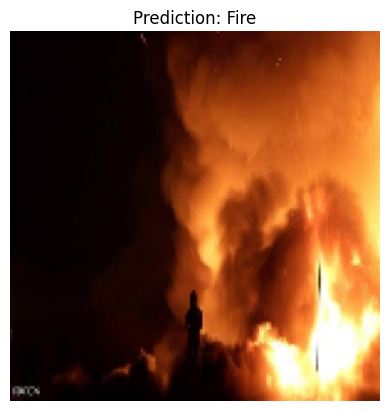

In [27]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis("off")

label = "Non-fire" if prediction[0][0] > 0.5 else "Fire"
plt.title(f"Prediction: {label}")
plt.show()

In [29]:
import random
import os
import matplotlib.pyplot as plt

# Test directory (change if needed)
test_dir = "/content/dataset_split/test"

# Collect all image paths from test folder
all_test_images = []
for cls in os.listdir(test_dir):   # ['cat', 'dog']
    cls_path = os.path.join(test_dir, cls)
    for img_file in os.listdir(cls_path):
        all_test_images.append(os.path.join(cls_path, img_file))

# Pick 10 random images
sample_images = random.sample(all_test_images, 10)

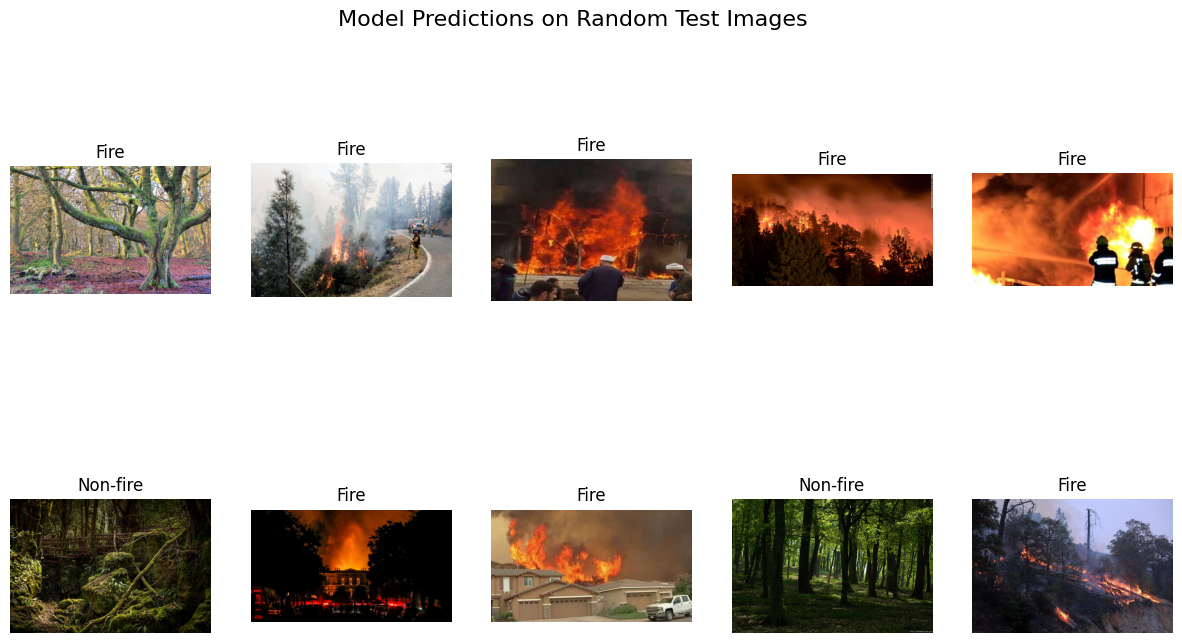

In [31]:
from tensorflow.keras.preprocessing import image
import numpy as np

plt.figure(figsize=(15, 8))

for i, img_path in enumerate(sample_images):
    # Load & preprocess
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    prediction = model.predict(img_array, verbose=0)
    label = "Non-fire" if prediction[0][0] > 0.5 else "Fire"

    # Plot
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
    plt.imshow(image.load_img(img_path))  # show original image
    plt.axis("off")
    plt.title(label)

plt.suptitle("Model Predictions on Random Test Images", fontsize=16)
plt.show()